In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import PolynomialFeatures,MaxAbsScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.model_selection import cross_val_score, train_test_split as split

from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding

from sklearn.metrics import roc_curve, mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [0]:
data = pd.read_csv("train.csv")

In [0]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

In [0]:
#Unique values in the columns
pd.set_option("display.max_colwidth", 0)
data[["property_type", "room_type", "bed_type", "cancellation_policy", "cleaning_fee", "city", "host_has_profile_pic",
     "host_identity_verified", "host_response_rate", "instant_bookable", "neighbourhood"]].agg(["unique"]).transpose()

,unique
property_type,"[Apartment, House, Condominium, Loft, Townhouse, Hostel, Guest suite, Bed & Breakfast, Bungalow, Guesthouse, Dorm, Other, Camper/RV, Villa, Boutique hotel, Timeshare, In-law, Boat, Serviced apartment, Castle, Cabin, Treehouse, Tipi, Vacation home, Tent, Hut, Casa particular, Chalet, Yurt, Earth House, Parking Space, Train, Cave, Lighthouse, Island]"
room_type,"[Entire home/apt, Private room, Shared room]"
bed_type,"[Real Bed, Futon, Pull-out Sofa, Couch, Airbed]"
cancellation_policy,"[strict, moderate, flexible, super_strict_30, super_strict_60]"
cleaning_fee,"[True, False]"
city,"[NYC, SF, DC, LA, Chicago, Boston]"
host_has_profile_pic,"[t, nan, f]"
host_identity_verified,"[t, f, nan]"
host_response_rate,"[nan, 100%, 71%, 68%, 67%, 83%, 50%, 90%, 86%, 92%, 82%, 80%, 89%, 93%, 99%, 0%, 88%, 96%, 70%, 94%, 91%, 25%, 95%, 98%, 62%, 29%, 33%, 81%, 63%, 38%, 60%, 79%, 78%, 75%, 65%, 97%, 87%, 40%, 54%, 53%, 58%, 76%, 30%, 64%, 17%, 20%, 77%, 73%, 41%, 59%, 57%, 85%, 56%, 42%, 44%, 35%, 14%, 74%, 27%, 10%, 84%, 6%, 72%, 36%, 55%, 43%, 13%, 39%, 46%, 26%, 61%, 52%, 23%, 22%, 69%, 66%, 15%, 11%, 31%, 21%, 47%]"
instant_bookable,"[f, t]"


In [0]:
data['property_type'].value_counts()

Apartment             49003
House                 16511
Condominium           2658 
Townhouse             1692 
Loft                  1244 
Other                 607  
Guesthouse            498  
Bed & Breakfast       462  
Bungalow              366  
Villa                 179  
Dorm                  142  
Guest suite           123  
Camper/RV             94   
Timeshare             77   
Cabin                 72   
In-law                71   
Hostel                70   
Boutique hotel        69   
Boat                  65   
Serviced apartment    21   
Tent                  18   
Castle                13   
Vacation home         11   
Yurt                  9    
Hut                   8    
Treehouse             7    
Chalet                6    
Earth House           4    
Tipi                  3    
Train                 2    
Cave                  2    
Island                1    
Parking Space         1    
Casa particular       1    
Lighthouse            1    
Name: property_type,

In [0]:
#Converting 35 propeties to 5
dict1 = {"Aprtment" : ['Condominium','Timeshare','Loft','Serviced apartment','Guest suite'],
        "House" : ['Vacation home','Villa','Townhouse','In-law','Casa particular'],
        "Hotel1" : ["Dorm", "Hostel", "Guesthouse"],
        "Hotel2" : ['Boutique hotel','Bed & Breakfast'],
        "Other" : ['Island','Castle','Yurt','Hut','Chalet','Treehouse',
                  'Earth House','Tipi','Cave','Train','Parking Space','Lighthouse',
                 'Tent','Boat','Cabin','Camper/RV','Bungalow']}

In [0]:
dict2 = {i : k for k, v in dict1.items() for i in v}
data["property_type"].replace(dict2).value_counts()

Apartment    49003
House        18465
Aprtment     4123 
Other        1279 
Hotel1       710  
Hotel2       531  
Name: property_type, dtype: int64

In [0]:
data["neighbourhood"].nunique()

619

In [0]:
pd.DataFrame(data.groupby(["city"])["neighbourhood"].nunique())

,neighbourhood
city,
Boston,34
Chicago,80
DC,116
LA,157
NYC,201
SF,55


In [0]:
def str_to_bool(s):
    if s=='t':
        return True
    else: 
        return False

In [0]:
def str_to_rate(s):
    if pd.isnull(s)==False:
        return float(s.replace('%',''))
    else: 
        return s

In [0]:
def extract_list_val(s):
    for c in ['{','}','"']:
        s=s.replace(c,'')
    for c in ['/',':',' ','-','.','&',')','(','\'']:
        s=s.replace(c,'_')
    s=s.replace('matress','mattress')
    return s.split(',')

In [0]:
def preprocessing_w_lat_long(data):
  data = data[data["log_price"] != 0]
  data.drop(columns = ["id", "last_review", "name", "neighbourhood", "host_has_profile_pic", "host_since", "description",
                      "first_review", "thumbnail_url", "zipcode"], inplace = True)
  data['property_type']=data['property_type'].replace(dict2)
  data['room_type']=data['room_type'].str.replace(' ','_')
  data['bed_type']=data['bed_type'].str.replace(' ','_')
  data['host_response_rate'] =data['host_response_rate'].apply(str_to_rate)
  data['host_identity_verified']=data['host_identity_verified'].apply(str_to_bool)
  data['instant_bookable']=data['instant_bookable'].apply(str_to_bool).astype(float)
  data['cleaning_fee']=data['cleaning_fee'].apply(str_to_bool).astype(float)
  data['amenities']=data['amenities'].apply(extract_list_val).str.join(' ')
  
  return data

In [0]:
def MAE(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [0]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
#functions to get columns for featrue tranformers   
def get_col_to_fillna_most_frequent(df):
    return df[col_to_fillna_most_frequent]

def get_col_to_fillna_mean(df):
    return df[col_to_fillna_mean]

def get_col_to_get_dummies(df):
    return df[col_to_getdummies]


def get_col_to_get_dummies_NYC(df):
    return df[col_to_getdummies_NYC]

def get_lat_long(df):
    return df[['latitude','longitude']]

def get_amenities(df):
    return df['amenities']

def get_amenities2(df):
    return df[['amenities']]

def get_col_no_change(df):
    return df[col_no_change]

def get_sum_amenities(s):
    return pd.DataFrame(s.apply(lambda s: len(s.split(' '))))

In [0]:
def get_results (pipes_dict, X_train, y_train,  X_test, y_test, num_cv, 
                 n_verbose, scoring_param, df_data_and_results, df_all_results):
    for name,model in pipes_dict.items():
        mean_cv_score=get_mean_cv_score(name ,model, X_train, y_train, num_cv, n_verbose,scoring_param)
        print ('Begin '+name+' model fit')
        t1 = time.time()
        model.fit(X_train,y_train)
        t2 = time.time()
        h, m ,s=time_convert(t2-t1)
        print('Model fit ended. Elapsed time: {0:.0f} hours, {1:.0f} minutes and {2:.0f} seconds'.format(h,m,s))
        y_pred=model.predict(X_test)
        df_data_and_results[('Price_pred_'+name)]=np.exp(y_pred)
        df_data_and_results[('Price_diff_'+name)]=np.exp(y_test)-np.exp(y_pred)
        df_all_results=df_all_results.append ({ 'Model':name,
                                                'CV_train_mean_MAE_score': mean_cv_score,
                                                'Test_MAE_score':          round(MAE(y_test,y_pred), 4),
                                                'Min_diff':                 df_data_and_results[('Price_diff_'+name)].min(),
                                                'Max_diff':                 df_data_and_results[('Price_diff_'+name)].max(), 
                                                'Mean_diff':                df_data_and_results[('Price_diff_'+name)].mean(), 
                                                'Median_diff':              df_data_and_results[('Price_diff_'+name)].median(),
                                                'STD_diff':                 df_data_and_results[('Price_diff_'+name)].std(),
                                                '10th percentile':          df_data_and_results[('Price_diff_'+name)].quantile(q=[0.1,0.9], interpolation='linear')[0.1],
                                                '90th percentile':          df_data_and_results[('Price_diff_'+name)].quantile(q=[0.1,0.9], interpolation='linear')[0.9]
                                              },
                                                ignore_index = True)
        print('======================================================================================\n')
    return df_data_and_results, df_all_results

In [0]:
def get_diff_hist (pipes_dict,df_data_and_results, df_all_results):
    for name,model in pipes_dict.items():
        fig, ax = plt.subplots(figsize=(14,5))
        sns.set_context(rc={"lines.linewidth": 3.5})#
        sns.distplot(df_data_and_results[('Price_diff_'+name)],ax=ax,color='red')
        plt.title(name+' Price_diff histogram')
        ax.set_xlim(df_all_results['Min_diff'].min(),df_all_results['Max_diff'].max())

def get_prediction_cluster_graph(pipes_dict, y_test, df_data_and_results):
    for name,model in pipes_dict.items():
        plt.figure()
        plt.plot(y_test,np.log(df_data_and_results[('Price_pred_'+name)]),'.', label = 'Result Data')
        plt.plot([2,9],[2,9], label = 'Ideal')
        plt.axes().set_aspect('equal')
        plt.legend()
        plt.title(name+' (y_true,y_pred) vs. ideal')

In [0]:
#functions for model fit, predict and results
def time_convert (t):
    h,m1=divmod(t, 3600)
    m,s=divmod(m1, 60) 
    return h, m ,s

def get_mean_cv_score(name, model, X_train, y_train, num_cv, n_verbose,scoring_param):
    print ('Model: '+name)
    print ('Begin CV fit')
    t0 = time.time()
    c_val=cross_val_score(model, X_train, y_train, cv=num_cv, verbose=n_verbose, scoring=scoring_param)
    t1 = time.time()
    h, m ,s=time_convert(t1-t0)
    print('CV ended. Elapsed time: {0:.0f} hours, {1:.0f} minutes and {2:.0f} seconds'.format(h,m,s))
    return -(c_val.mean().round(4))


In [0]:
data_clean_all = data.copy()

In [0]:
data_clean_all = preprocessing_w_lat_long(data_clean_all)

In [0]:
data_clean_all.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,5.010635,Apartment,Entire_home/apt,Wireless_Internet Air_conditioning Kitchen Heating Family_kid_friendly Essentials Hair_dryer Iron translation_missing__en_hosting_amenity_50,3,1.0,Real_Bed,strict,0.0,NYC,True,NaN,0.0,40.696524,-73.991617,2,100.0,1.0,1.0
1,5.129899,Apartment,Entire_home/apt,Wireless_Internet Air_conditioning Kitchen Heating Family_kid_friendly Washer Dryer Smoke_detector Fire_extinguisher Essentials Shampoo Hangers Hair_dryer Iron translation_missing__en_hosting_amenity_50,7,1.0,Real_Bed,strict,0.0,NYC,False,100.0,1.0,40.766115,-73.989040,6,93.0,3.0,3.0
2,4.976734,Apartment,Entire_home/apt,TV Cable_TV Wireless_Internet Air_conditioning Kitchen Breakfast Buzzer_wireless_intercom Heating Family_kid_friendly Smoke_detector Carbon_monoxide_detector Fire_extinguisher Essentials Shampoo Hangers Hair_dryer Iron Laptop_friendly_workspace translation_missing__en_hosting_amenity_50,5,1.0,Real_Bed,moderate,0.0,NYC,True,100.0,1.0,40.808110,-73.943756,10,92.0,1.0,3.0
3,6.620073,House,Entire_home/apt,TV Cable_TV Internet Wireless_Internet Kitchen Indoor_fireplace Buzzer_wireless_intercom Heating Washer Dryer Smoke_detector Carbon_monoxide_detector First_aid_kit Fire_extinguisher Essentials,4,1.0,Real_Bed,flexible,0.0,SF,True,NaN,0.0,37.772004,-122.431619,0,NaN,2.0,2.0
4,4.744932,Apartment,Entire_home/apt,TV Internet Wireless_Internet Air_conditioning Kitchen Elevator_in_building Heating Smoke_detector Carbon_monoxide_detector Fire_extinguisher Essentials Shampoo,2,1.0,Real_Bed,moderate,0.0,DC,True,100.0,1.0,38.925627,-77.034596,4,40.0,0.0,1.0


In [0]:
data_clean_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74110 entries, 0 to 74110
Data columns (total 19 columns):
log_price                 74110 non-null float64
property_type             74110 non-null object
room_type                 74110 non-null object
amenities                 74110 non-null object
accommodates              74110 non-null int64
bathrooms                 73910 non-null float64
bed_type                  74110 non-null object
cancellation_policy       74110 non-null object
cleaning_fee              74110 non-null float64
city                      74110 non-null object
host_identity_verified    74110 non-null bool
host_response_rate        55811 non-null float64
instant_bookable          74110 non-null float64
latitude                  74110 non-null float64
longitude                 74110 non-null float64
number_of_reviews         74110 non-null int64
review_scores_rating      57388 non-null float64
bedrooms                  74019 non-null float64
beds                  

In [0]:
data_clean_all.shape

(74110, 19)

In [0]:
#columns to fill Nan with most frequent
col_to_fillna_most_frequent=['beds','bedrooms','bathrooms','host_identity_verified']

#columns to fill Nan with mean
col_to_fillna_mean=['host_response_rate','review_scores_rating']

#columns for get_dummies (one hot encoding)
col_to_getdummies=['property_type','room_type','bed_type','cancellation_policy','city']

#columns that won't be changed
col_no_change=['accommodates','number_of_reviews']

In [0]:
data_clean_all.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,5.010635,Apartment,Entire_home/apt,Wireless_Internet Air_conditioning Kitchen Heating Family_kid_friendly Essentials Hair_dryer Iron translation_missing__en_hosting_amenity_50,3,1.0,Real_Bed,strict,0.0,NYC,True,NaN,0.0,40.696524,-73.991617,2,100.0,1.0,1.0
1,5.129899,Apartment,Entire_home/apt,Wireless_Internet Air_conditioning Kitchen Heating Family_kid_friendly Washer Dryer Smoke_detector Fire_extinguisher Essentials Shampoo Hangers Hair_dryer Iron translation_missing__en_hosting_amenity_50,7,1.0,Real_Bed,strict,0.0,NYC,False,100.0,1.0,40.766115,-73.989040,6,93.0,3.0,3.0
2,4.976734,Apartment,Entire_home/apt,TV Cable_TV Wireless_Internet Air_conditioning Kitchen Breakfast Buzzer_wireless_intercom Heating Family_kid_friendly Smoke_detector Carbon_monoxide_detector Fire_extinguisher Essentials Shampoo Hangers Hair_dryer Iron Laptop_friendly_workspace translation_missing__en_hosting_amenity_50,5,1.0,Real_Bed,moderate,0.0,NYC,True,100.0,1.0,40.808110,-73.943756,10,92.0,1.0,3.0
3,6.620073,House,Entire_home/apt,TV Cable_TV Internet Wireless_Internet Kitchen Indoor_fireplace Buzzer_wireless_intercom Heating Washer Dryer Smoke_detector Carbon_monoxide_detector First_aid_kit Fire_extinguisher Essentials,4,1.0,Real_Bed,flexible,0.0,SF,True,NaN,0.0,37.772004,-122.431619,0,NaN,2.0,2.0
4,4.744932,Apartment,Entire_home/apt,TV Internet Wireless_Internet Air_conditioning Kitchen Elevator_in_building Heating Smoke_detector Carbon_monoxide_detector Fire_extinguisher Essentials Shampoo,2,1.0,Real_Bed,moderate,0.0,DC,True,100.0,1.0,38.925627,-77.034596,4,40.0,0.0,1.0


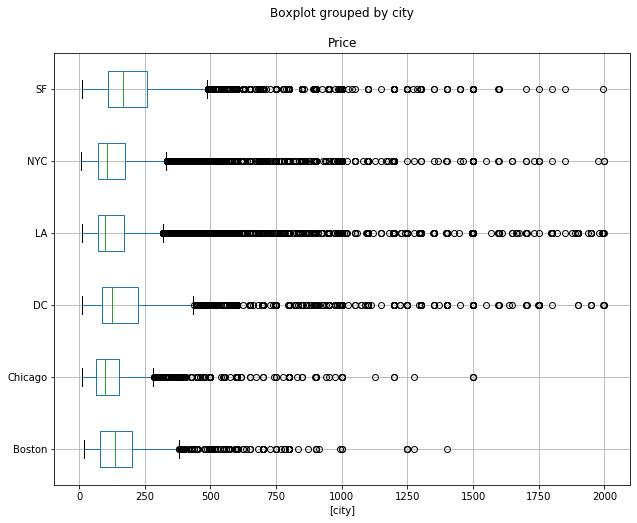

In [0]:
#Visualizing
city_price_df = data_clean_all.copy()[['city','log_price']]
city_price_df['Price'] = np.exp(city_price_df['log_price'])
city_price_df[['city','Price']].boxplot(by = 'city', figsize=(10, 8), vert=False)

In [0]:
#Linear Regression
#Scoring Functions
MAE_scorer = make_scorer(MAE, greater_is_better=False)
MAPE_scorer = make_scorer(MAPE, greater_is_better=False)

In [0]:
KNN_neighbors=200
RF_n_estimators=50
RF_min_samples_split=50
TSVD_n_components=10
num_cv=5
n_verbose = 3
scoring_param=MAE_scorer

In [0]:
PCA_features=PCA()
TruncatedSVD_features=TruncatedSVD(n_components=TSVD_n_components)
lin_regressor= LinearRegression()
RF_regressor = RandomForestRegressor(n_estimators=RF_n_estimators, min_samples_split=RF_min_samples_split)
KNN_Reg = KNNR(n_neighbors=KNN_neighbors)

In [0]:
#Buliding a transformer
class MyTransformer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, model):
        self.model=model
        pass

    def fit(self, X, y=None):
        self.model.fit(X, np.exp(y))
        return self

    def transform(self, X):
        # transform X via code or additional methods
        return pd.DataFrame(self.model.predict(X))

In [0]:
Transformer_fillna_most_frequent = Pipeline([('Select_col_to_fillna_most_frequent', FunctionTransformer(func=get_col_to_fillna_most_frequent, validate=False)),
                                            ('Fill_Null',                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ('To_float_transformer',                FunctionTransformer(func=lambda x: x.astype(float) ,validate=False))
                                            ])

In [0]:
Transformer_fillna_mean = Pipeline([('Select_col_to_fillna_mean',    FunctionTransformer(func=get_col_to_fillna_mean, validate=False)),
                                    ('Fill_Null',                    SimpleImputer(missing_values=np.nan, strategy='mean'))
                                  ])

In [0]:
Transformer_OneHotEncoder= Pipeline([('Select_col_to_get_dummies',      FunctionTransformer(func=get_col_to_get_dummies, validate=False)),
                                     ('OneHotEncoder_transform',        OneHotEncoder(handle_unknown='ignore'))
                                  ])

In [0]:
Transformer_amenities = Pipeline([('Select_col_to_get_amenities',  FunctionTransformer(func=get_amenities, validate=False)),
                                  ('CountVectorizer_transform',    CountVectorizer(min_df=0.02)),
                                  ('Feature_extractor_TSVD',     TruncatedSVD_features)
                                 ])


In [0]:
Transformer_sum_amenities=Pipeline([('Select_col_to_get_amenities',  FunctionTransformer(func=get_amenities, validate=False)),
                                    ('Get_sum_amenities',            FunctionTransformer(func=get_sum_amenities, validate=False)),
                                   ])

In [0]:
Transformer_get_columns = Pipeline ([('Select_col_no_change', FunctionTransformer(func=get_col_no_change, validate=False))])

In [0]:
Transformer_lat_long = Pipeline ([('Select_col_lat_long_price', FunctionTransformer(func=get_lat_long, validate=False)),                                
                                  ('MyTransformer', MyTransformer(KNN_Reg))    
                                ])

In [0]:
FeatureUnionTransformer = FeatureUnion([('FTfillna_frequent',   Transformer_fillna_most_frequent),
                                        ('FTfillna_mean',       Transformer_fillna_mean),
                                        ('FTget_OneHotEncoder', Transformer_OneHotEncoder),                  
                                        ('FTamenities',         Transformer_amenities),
                                        ('FT_sum_amenities',    Transformer_sum_amenities),
                                        ('FT_lat_long',         Transformer_lat_long),
                                        ('FT_get_columns',      Transformer_get_columns)
                                       ])

In [0]:
#Transformer with polynomial features
Full_Transformer_poly = Pipeline([('Feature_Engineering', FeatureUnionTransformer),
                                  ('Polynomial_Transformer', PolynomialFeatures(degree=2, interaction_only=True)),
                                  ('Min_Max_Transformer', MaxAbsScaler())
                                 ])

#Transformer without polynomial features
Full_Transformer = Pipeline([('Feature_Engineering', FeatureUnionTransformer),
                             ('Min_Max_Transformer', MaxAbsScaler())
                            ])

In [0]:
#Regression model piplines
lin_reg_pipe= Pipeline([('Feature_transformer', Full_Transformer),
                        ('Linear_regressor', lin_regressor)
                       ])

lin_reg_poly_pipe= Pipeline([('Feature_transformer_poly', Full_Transformer_poly),
                             ('Linear_regressor', lin_regressor)
                            ])

RF_pipe= Pipeline([('Feature_transformer', Full_Transformer),
                    ('RFE_regressor', RF_regressor)
                  ])

RF_poly_pipe= Pipeline([('Feature_transformer_poly', Full_Transformer_poly),
                        ('RFE_regressor', RF_regressor)
                       ])

In [0]:
X_train_all, X_test_all, y_train_all, y_test_all = split(data_clean_all.drop(axis=1, columns=['log_price']), 
                                                         data_clean_all['log_price'], 
                                                         test_size =0.3, random_state=123)


In [0]:
pipes_dict_all = {'LG':lin_reg_pipe, 'LG_poly':lin_reg_poly_pipe,'RF':RF_pipe, 'RF_poly':RF_poly_pipe}

#reset DF to collect results
df_all_results_all=pd.DataFrame(columns=['Model','CV_train_mean_MAE_score','Test_MAE_score',
                                          'Min_diff','Max_diff','Mean_diff','Median_diff',
                                          'STD_diff','10th percentile','90th percentile'])

df_data_and_results_all=X_test_all.copy()
df_data_and_results_all['Price_true']=np.exp(y_test_all)

In [0]:
#Run Models:
df_data_and_results_all, df_all_results_all =get_results(pipes_dict_all, X_train_all, y_train_all, X_test_all, y_test_all, 
                                                         num_cv, n_verbose, scoring_param, 
                                                         df_data_and_results_all, df_all_results_all)

Model: LG
Begin CV fit
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... , score=-0.307, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ................................... , score=-0.303, total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s


[CV] ................................... , score=-0.315, total=   4.3s
[CV]  ................................................................
[CV] ................................... , score=-0.306, total=   4.3s
[CV]  ................................................................
[CV] ................................... , score=-0.304, total=   4.2s
CV ended. Elapsed time: 0 hours, 0 minutes and 22 seconds
Begin LG model fit


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.6s finished


Model fit ended. Elapsed time: 0 hours, 0 minutes and 5 seconds

Model: LG_poly
Begin CV fit
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... , score=-0.292, total= 2.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] ................................... , score=-0.293, total= 2.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


[CV] ................................... , score=-0.301, total= 2.2min
[CV]  ................................................................
[CV] ................................... , score=-0.296, total= 2.2min
[CV]  ................................................................
[CV] ................................... , score=-0.293, total= 2.2min
CV ended. Elapsed time: 0 hours, 11 minutes and 10 seconds
Begin LG_poly model fit


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.2min finished


Model fit ended. Elapsed time: 0 hours, 2 minutes and 46 seconds

Model: RF
Begin CV fit
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... , score=-0.294, total= 2.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] ................................... , score=-0.291, total= 2.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.1min remaining:    0.0s


[CV] ................................... , score=-0.297, total= 2.6min
[CV]  ................................................................
[CV] ................................... , score=-0.292, total= 2.6min
[CV]  ................................................................
[CV] ................................... , score=-0.288, total= 2.6min
CV ended. Elapsed time: 0 hours, 12 minutes and 54 seconds
Begin RF model fit


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.9min finished


Model fit ended. Elapsed time: 0 hours, 3 minutes and 27 seconds

Model: RF_poly
Begin CV fit
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... , score=-0.290, total=49.1min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 49.1min remaining:    0.0s


[CV] ................................... , score=-0.288, total=49.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 98.6min remaining:    0.0s


[CV] ................................... , score=-0.295, total=49.5min
[CV]  ................................................................
[CV] ................................... , score=-0.287, total=49.1min
[CV]  ................................................................
[CV] ................................... , score=-0.284, total=49.0min
CV ended. Elapsed time: 4 hours, 6 minutes and 13 seconds
Begin RF_poly model fit


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 246.2min finished


In [0]:
df_all_results_all

In [0]:
get_prediction_cluster_graph(pipes_dict_all, y_test_all, df_data_and_results_all)

In [0]:
get_diff_hist(pipes_dict_all, df_data_and_results_all, df_all_results_all)